In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Fri Jan 12 04:29:28 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 30%   27C    P8    13W / 230W |      8MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 30%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_vae_encoder import Encoder
from model.latent_layer.sampling_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.0202789306640625
encoder.convs 5.989013671875
encoder.linear 0.0312652587890625
latent_layer 3.814697265625e-06
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.12-1/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 151848
-rw-rw-r-- 1 scpark scpark      130  1월 12 04:29 events.out.tfevents.1705001279.GPUSVR01
-rw-rw-r-- 1 scpark scpark  3363104  1월 12 04:15 events.out.tfevents.1704998722.GPUSVR01
-rw-rw-r-- 1 scpark scpark 38028893  1월 12 04:10 save_30000
-rw-rw-r-- 1 scpark scpark 38028893  1월 12 04:02 save_20000
-rw-rw-r-- 1 scpark scpark 38028893  1월 12 03:54 save_10000
-rw-rw-r-- 1 scpark scpark 38023101  1월 12 03:45 save_0
-rw-rw-r-- 1 scpark scpark       40  1월 12 03:45 events.out.tfevents.1704998695.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


z_logvar : Parameter containing:
tensor([[-0.2926]], device='cuda:0', requires_grad=True)


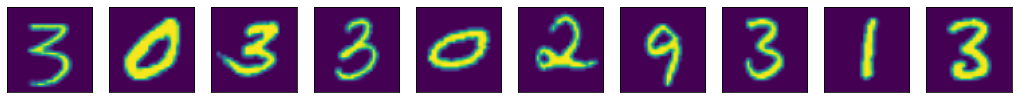

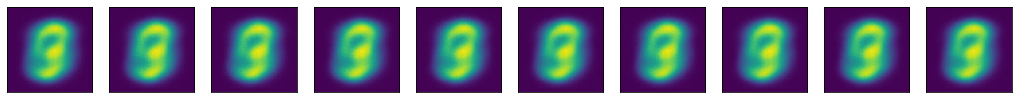

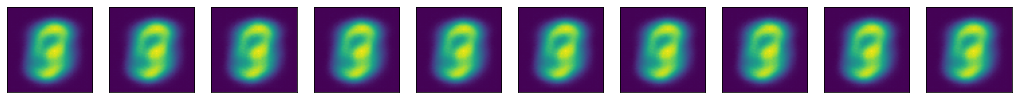

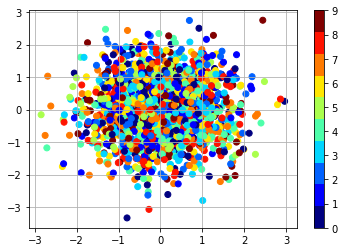

3001
lse_loss -4.394177436828613
recon_loss 0.22224712371826172
3002
lse_loss -4.399811267852783
recon_loss 0.23745813965797424
3003
lse_loss -4.3994340896606445
recon_loss 0.2343209981918335
3004
lse_loss -4.393246650695801
recon_loss 0.2288234680891037
3005
lse_loss -4.382588863372803
recon_loss 0.229387566447258
3006
lse_loss -4.398710250854492
recon_loss 0.22590778768062592
3007
lse_loss -4.393423557281494
recon_loss 0.2320556342601776
3008
lse_loss -4.3989667892456055
recon_loss 0.2187861204147339
3009
lse_loss -4.400548458099365
recon_loss 0.22199857234954834
3010
lse_loss -4.377666473388672
recon_loss 0.2351122945547104
3011
lse_loss -4.402585506439209
recon_loss 0.22789499163627625
3012
lse_loss -4.408778667449951
recon_loss 0.22636346518993378
3013
lse_loss -4.398322105407715
recon_loss 0.22044989466667175
3014
lse_loss -4.399235725402832
recon_loss 0.2252996861934662
3015
lse_loss -4.404781341552734
recon_loss 0.22315692901611328
3016
lse_loss -4.4023356437683105
recon_loss 0

3131
lse_loss -4.402822017669678
recon_loss 0.2230970859527588
3132
lse_loss -4.417835712432861
recon_loss 0.21838966012001038
3133
lse_loss -4.415700912475586
recon_loss 0.22983698546886444
3134
lse_loss -4.404959678649902
recon_loss 0.22312931716442108
3135
lse_loss -4.413920879364014
recon_loss 0.2188849300146103
3136
lse_loss -4.424797058105469
recon_loss 0.2448788732290268
3137
lse_loss -4.425036430358887
recon_loss 0.230465829372406
3138
lse_loss -4.422906398773193
recon_loss 0.22277604043483734
3139
lse_loss -4.422914505004883
recon_loss 0.2196855992078781
3140
lse_loss -4.4304423332214355
recon_loss 0.22632162272930145
3141
lse_loss -4.420124053955078
recon_loss 0.22407476603984833
3142
lse_loss -4.429379463195801
recon_loss 0.2235240638256073
3143
lse_loss -4.4237847328186035
recon_loss 0.22966133058071136
3144
lse_loss -4.437098503112793
recon_loss 0.22527194023132324
3145
lse_loss -4.4317097663879395
recon_loss 0.22277745604515076
3146
lse_loss -4.413825035095215
recon_loss 

3261
lse_loss -4.440124988555908
recon_loss 0.22576145827770233
3262
lse_loss -4.432531356811523
recon_loss 0.23586241900920868
3263
lse_loss -4.439093589782715
recon_loss 0.21991300582885742
3264
lse_loss -4.4548821449279785
recon_loss 0.2297726571559906
3265
lse_loss -4.435716152191162
recon_loss 0.22729778289794922
3266
lse_loss -4.4334588050842285
recon_loss 0.21869325637817383
3267
lse_loss -4.455504894256592
recon_loss 0.2227819859981537
3268
lse_loss -4.465921401977539
recon_loss 0.2308787703514099
3269
lse_loss -4.426032066345215
recon_loss 0.22358684241771698
3270
lse_loss -4.441815376281738
recon_loss 0.23039142787456512
3271
lse_loss -4.431527614593506
recon_loss 0.21446143090724945
3272
lse_loss -4.444554805755615
recon_loss 0.22034913301467896
3273
lse_loss -4.439915657043457
recon_loss 0.22145575284957886
3274
lse_loss -4.43488073348999
recon_loss 0.23212522268295288
3275
lse_loss -4.440923690795898
recon_loss 0.22704705595970154
3276
lse_loss -4.446378231048584
recon_los

3391
lse_loss -4.463386535644531
recon_loss 0.2244236171245575
3392
lse_loss -4.462071895599365
recon_loss 0.2243667095899582
3393
lse_loss -4.468323707580566
recon_loss 0.2236175537109375
3394
lse_loss -4.457876682281494
recon_loss 0.2305552214384079
3395
lse_loss -4.469595909118652
recon_loss 0.23552927374839783
3396
lse_loss -4.468106746673584
recon_loss 0.23061490058898926
3397
lse_loss -4.465709686279297
recon_loss 0.22373883426189423
3398
lse_loss -4.454379081726074
recon_loss 0.23852834105491638
3399
lse_loss -4.460971355438232
recon_loss 0.2325097918510437
3400
lse_loss -4.466087341308594
recon_loss 0.22190891206264496
3401
lse_loss -4.456338882446289
recon_loss 0.22418586909770966
3402
lse_loss -4.462387561798096
recon_loss 0.21782201528549194
3403
lse_loss -4.455821990966797
recon_loss 0.2259095311164856
3404
lse_loss -4.45580530166626
recon_loss 0.2185392826795578
3405
lse_loss -4.465137958526611
recon_loss 0.22992567718029022
3406
lse_loss -4.463336944580078
recon_loss 0.22

3521
lse_loss -4.487331390380859
recon_loss 0.22373485565185547
3522
lse_loss -4.479111671447754
recon_loss 0.2182210087776184
3523
lse_loss -4.494784832000732
recon_loss 0.21481990814208984
3524
lse_loss -4.476174354553223
recon_loss 0.2305431365966797
3525
lse_loss -4.494736194610596
recon_loss 0.21949195861816406
3526
lse_loss -4.475048065185547
recon_loss 0.2220485508441925
3527
lse_loss -4.498642444610596
recon_loss 0.23166438937187195
3528
lse_loss -4.491952419281006
recon_loss 0.2285146713256836
3529
lse_loss -4.479211807250977
recon_loss 0.2253449410200119
3530
lse_loss -4.482300281524658
recon_loss 0.22385036945343018
3531
lse_loss -4.485279083251953
recon_loss 0.22811660170555115
3532
lse_loss -4.472542762756348
recon_loss 0.2217329442501068
3533
lse_loss -4.498795986175537
recon_loss 0.23150043189525604
3534
lse_loss -4.491801738739014
recon_loss 0.22650283575057983
3535
lse_loss -4.499927043914795
recon_loss 0.21897290647029877
3536
lse_loss -4.482144832611084
recon_loss 0.

3651
lse_loss -4.497369766235352
recon_loss 0.2123744934797287
3652
lse_loss -4.521508693695068
recon_loss 0.24246293306350708
3653
lse_loss -4.502666473388672
recon_loss 0.2287762612104416
3654
lse_loss -4.497321605682373
recon_loss 0.22415760159492493
3655
lse_loss -4.505748748779297
recon_loss 0.23330068588256836
3656
lse_loss -4.516523838043213
recon_loss 0.22862963378429413
3657
lse_loss -4.51498556137085
recon_loss 0.2317710965871811
3658
lse_loss -4.505588531494141
recon_loss 0.22577635943889618
3659
lse_loss -4.498195648193359
recon_loss 0.22480779886245728
3660
lse_loss -4.49989128112793
recon_loss 0.22488752007484436
3661
lse_loss -4.5159101486206055
recon_loss 0.216354638338089
3662
lse_loss -4.49547815322876
recon_loss 0.2278168797492981
3663
lse_loss -4.511166095733643
recon_loss 0.227869912981987
3664
lse_loss -4.51507568359375
recon_loss 0.22633576393127441
3665
lse_loss -4.503109931945801
recon_loss 0.22928541898727417
3666
lse_loss -4.505918979644775
recon_loss 0.22686

3781
lse_loss -4.515319347381592
recon_loss 0.21939760446548462
3782
lse_loss -4.519367218017578
recon_loss 0.22258660197257996
3783
lse_loss -4.52728796005249
recon_loss 0.22748121619224548
3784
lse_loss -4.536114692687988
recon_loss 0.22968608140945435
3785
lse_loss -4.531147480010986
recon_loss 0.2191082090139389
3786
lse_loss -4.533387660980225
recon_loss 0.23682624101638794
3787
lse_loss -4.538788318634033
recon_loss 0.21941648423671722
3788
lse_loss -4.526978015899658
recon_loss 0.23477189242839813
3789
lse_loss -4.525383472442627
recon_loss 0.2358836978673935
3790
lse_loss -4.5315752029418945
recon_loss 0.23029892146587372
3791
lse_loss -4.516717433929443
recon_loss 0.2311045378446579
3792
lse_loss -4.524967193603516
recon_loss 0.22605381906032562
3793
lse_loss -4.518329620361328
recon_loss 0.21806347370147705
3794
lse_loss -4.527410507202148
recon_loss 0.2229609489440918
3795
lse_loss -4.539018630981445
recon_loss 0.22787731885910034
3796
lse_loss -4.534356594085693
recon_loss 

3911
lse_loss -4.545508861541748
recon_loss 0.22234082221984863
3912
lse_loss -4.54890251159668
recon_loss 0.2252158373594284
3913
lse_loss -4.5496625900268555
recon_loss 0.23830652236938477
3914
lse_loss -4.556646823883057
recon_loss 0.23013651371002197
3915
lse_loss -4.553768157958984
recon_loss 0.21973490715026855
3916
lse_loss -4.5427422523498535
recon_loss 0.22921204566955566
3917
lse_loss -4.547018527984619
recon_loss 0.2345166653394699
3918
lse_loss -4.550900459289551
recon_loss 0.22824645042419434
3919
lse_loss -4.550430774688721
recon_loss 0.2280343621969223
3920
lse_loss -4.553356647491455
recon_loss 0.22288036346435547
3921
lse_loss -4.546372413635254
recon_loss 0.2347593754529953
3922
lse_loss -4.546954154968262
recon_loss 0.22640864551067352
3923
lse_loss -4.549122333526611
recon_loss 0.2293504923582077
3924
lse_loss -4.552502155303955
recon_loss 0.22623591125011444
3925
lse_loss -4.549492835998535
recon_loss 0.21689841151237488
3926
lse_loss -4.568100452423096
recon_loss 

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=10000)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000)
                
            print('z_logvar :', model.latent_layer.z_logvar)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        

In [ ]:
model.latent_layer.z_logvar